# Модель для средней заработной платы в РФ


Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.


In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


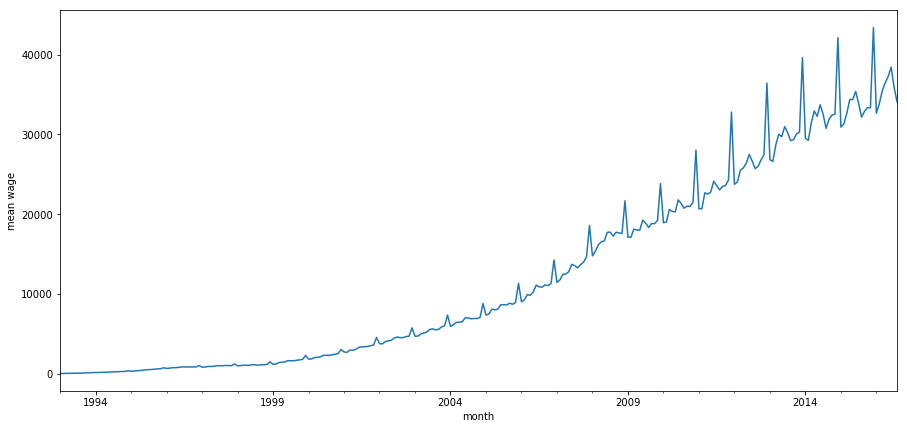

In [3]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('mean wage')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


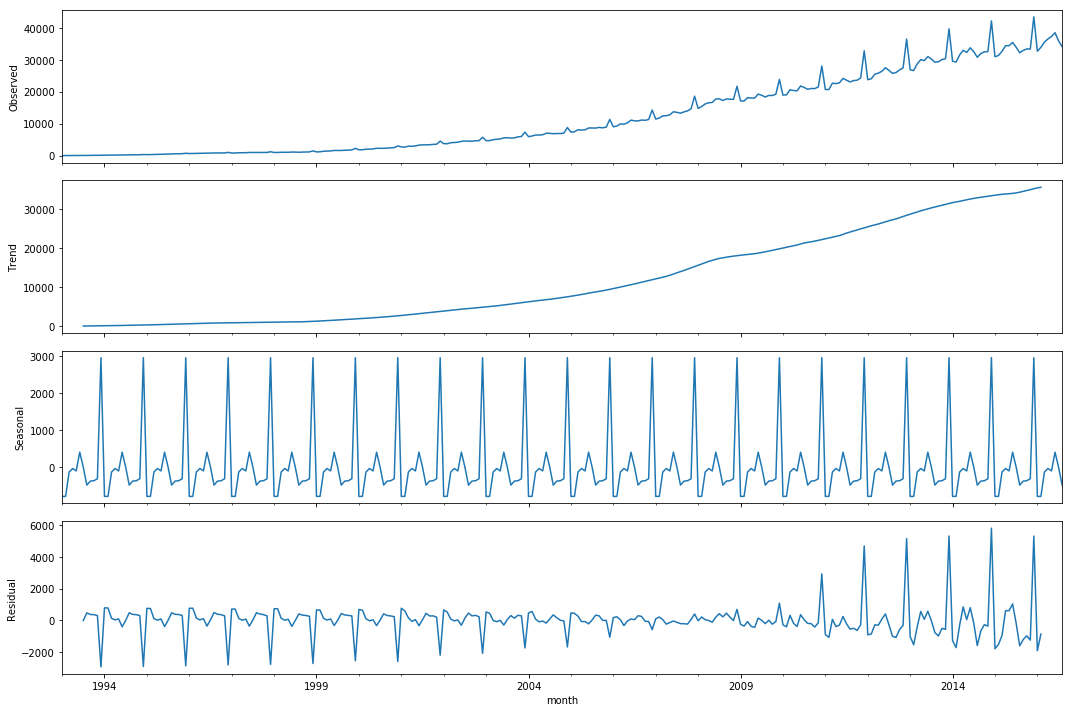

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

## Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


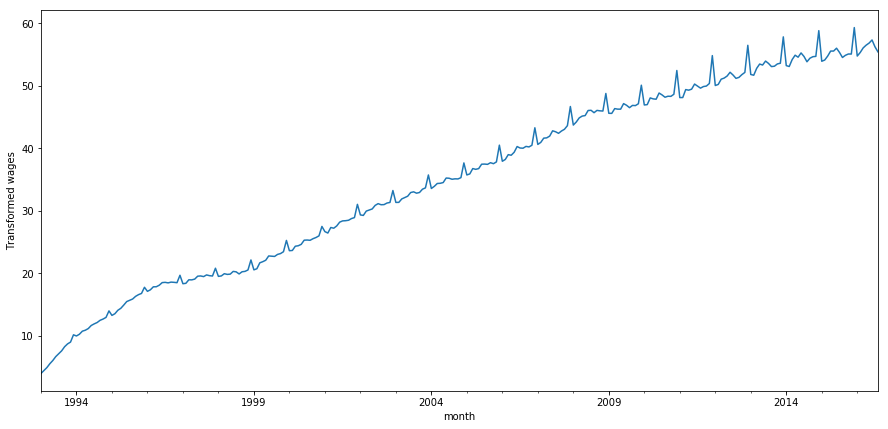

In [5]:
data['wage_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

## Дифференцирование и стационарность

Сезонное дифференцирование:

Критерий Дики-Фуллера: p=0.014697


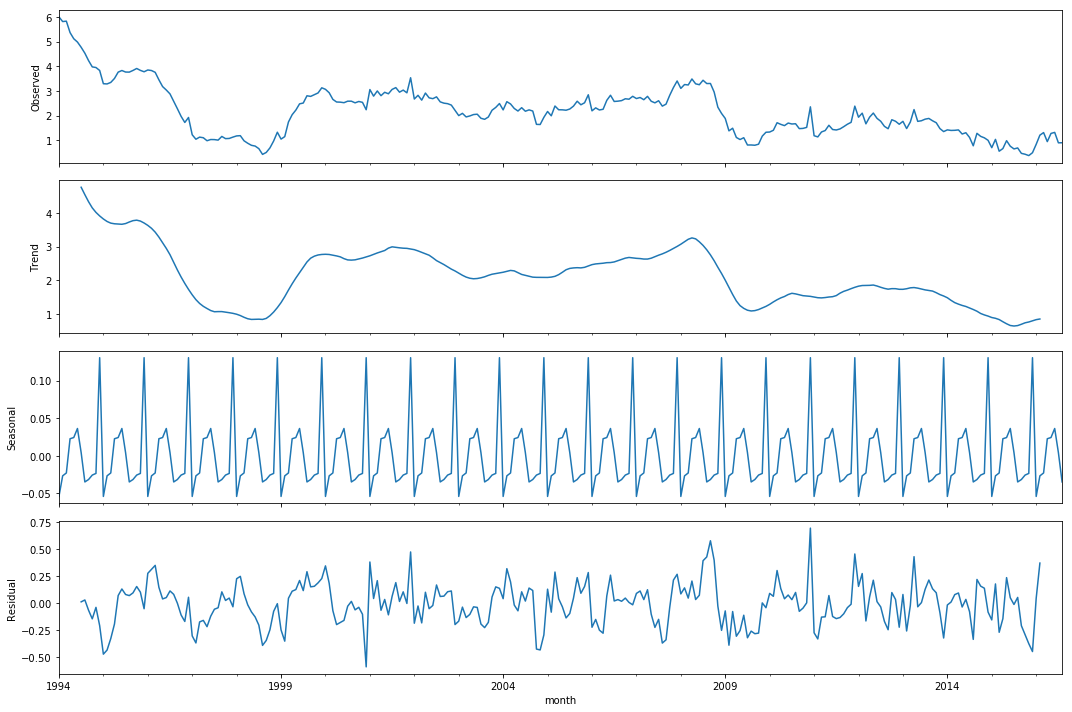

In [6]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но тренд еще не похож на случайный, попробуем еще простое дифференцирование.

Критерий Дики-Фуллера: p=0.000000


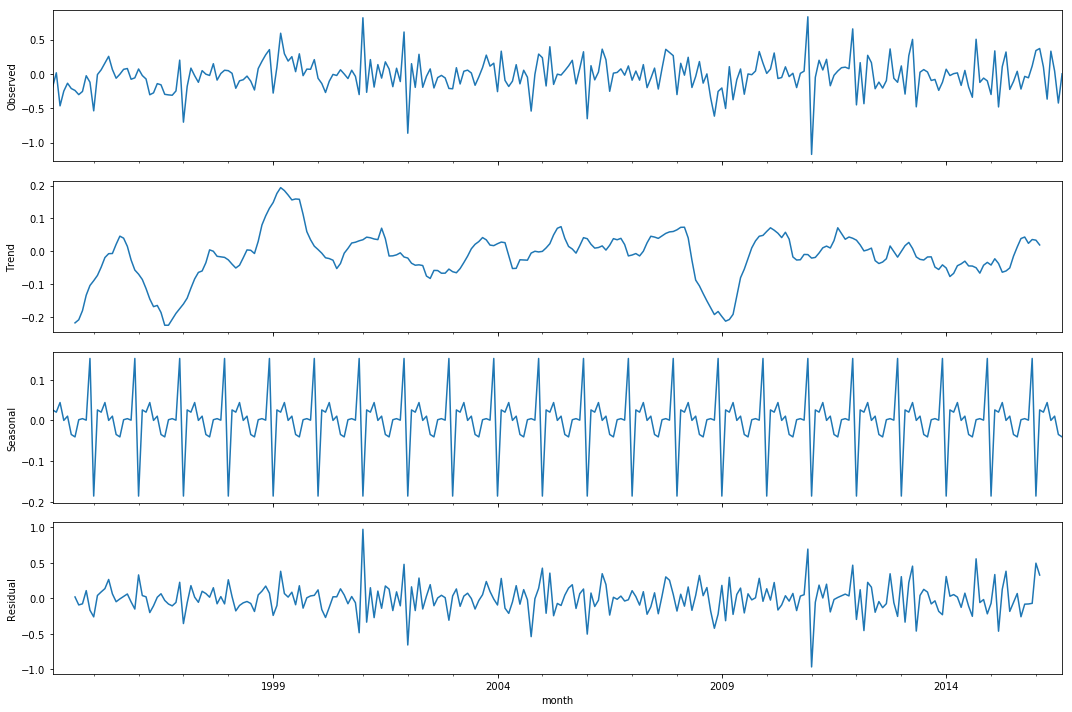

In [7]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, оставляем полученный ряд.

## Подбор параметров p, q, P, Q

Посмотрим на ACF и PACF полученного ряда:

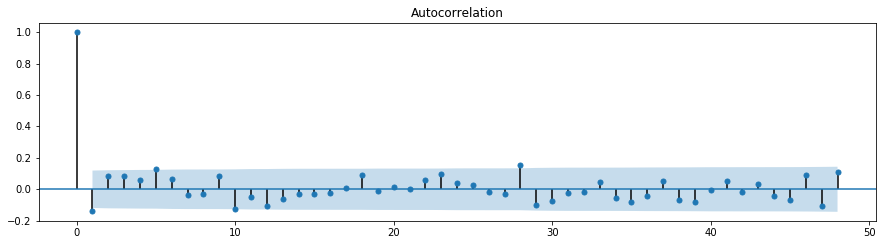

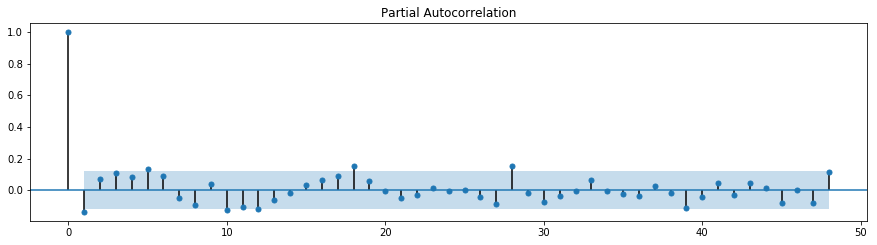

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Предлагается взять  p = 5, q = 1, P = 1, Q = 1,

In [9]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps= range(0, 2)
D=1
Qs = range(0, 2)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
Wall time: 50.1 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True)[:10])

      parameters       aic
41  (5, 1, 1, 0) -5.260133
42  (5, 1, 1, 1) -5.074467
25  (3, 1, 1, 0) -4.995860
37  (5, 0, 1, 0) -4.545934
40  (5, 1, 0, 1) -4.447610
38  (5, 0, 1, 1) -4.387352
24  (3, 1, 0, 1) -4.342767
26  (3, 1, 1, 1) -4.312788
36  (5, 0, 0, 1) -4.042377
33  (4, 1, 1, 0) -3.975974


Лучшая модель с (p, d, q, P, D, Q) = (5, 1, 1, 1, 1, 0), но качество более простой модели с (p, d, q, P, D, Q) = (3, 1, 1, 1, 1, 0) не сильно хуже, проверим обе и выберем лучшую. Данные лучшей сложной модели (p = 5):

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Fri, 13 Oct 2017   AIC                             -5.260
Time:                                    13:51:31   BIC                             23.932
Sample:                                01-01-1993   HQIC                             6.443
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2015      0.436      0.462      0.644      -0.654       1.057
ar.L2          0.0993      0.105   

Смущает, что все коффициенты при переменных оказались незначимы.

Данные лучшей простой модели (p, q = 3,1):

In [15]:
simple_model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(3, d, 1), 
                                        seasonal_order=(1, D, 0, 12)).fit(disp=-1)

In [29]:
print(simple_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Fri, 13 Oct 2017   AIC                             -4.996
Time:                                    13:43:32   BIC                             16.898
Sample:                                01-01-1993   HQIC                             3.782
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4854      0.210      2.313      0.021       0.074       0.897
ar.L2          0.1630      0.075   

Здесь коэффициенты значимы. Построим прогноз для наших моделей по очереди.

## Для лучшей сложной модели

Остатки

Критерий Стьюдента: p=0.296163
Критерий Дики-Фуллера: p=0.000000


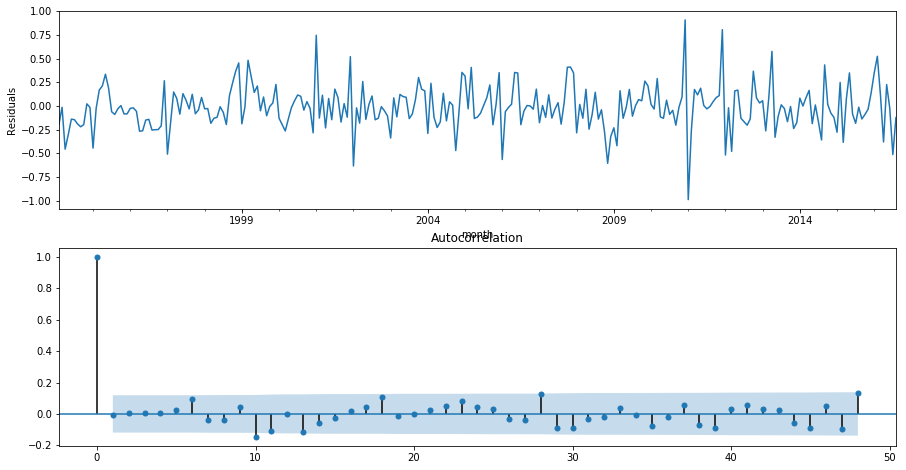

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

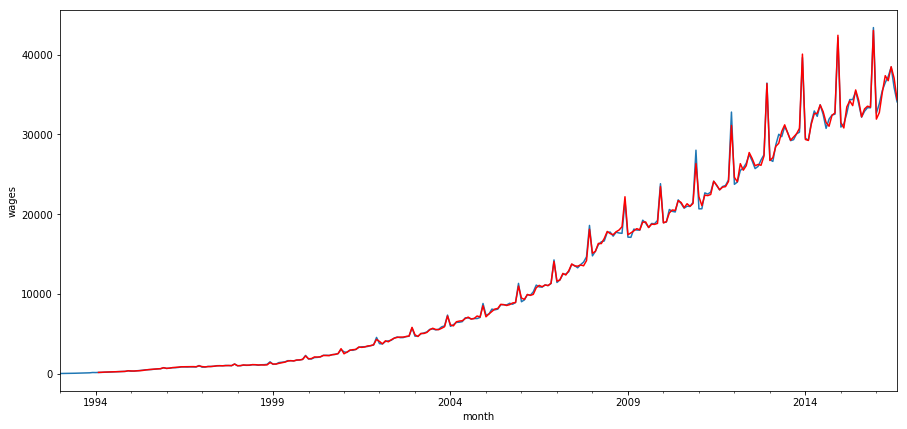

In [18]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('wages')
pylab.show()

Данные описаны достаточно точно.

### Прогноз

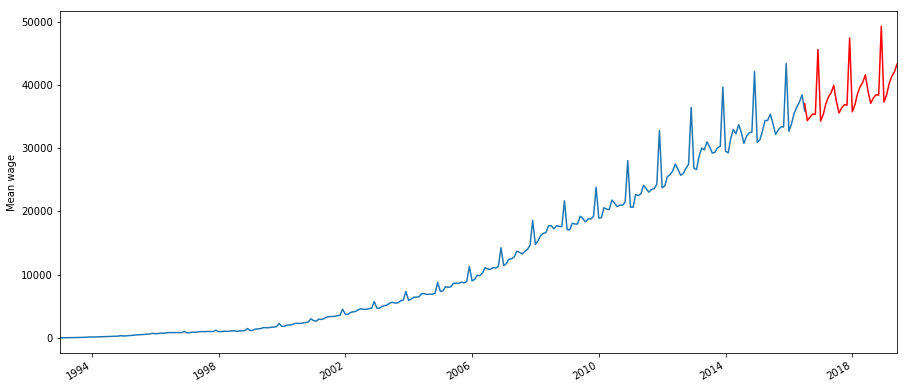

In [19]:
data2 =  data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=282, end=320), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Mean wage')
pylab.show()

## Для лучшей простой модели

Критерий Стьюдента: p=0.281896
Критерий Дики-Фуллера: p=0.000000


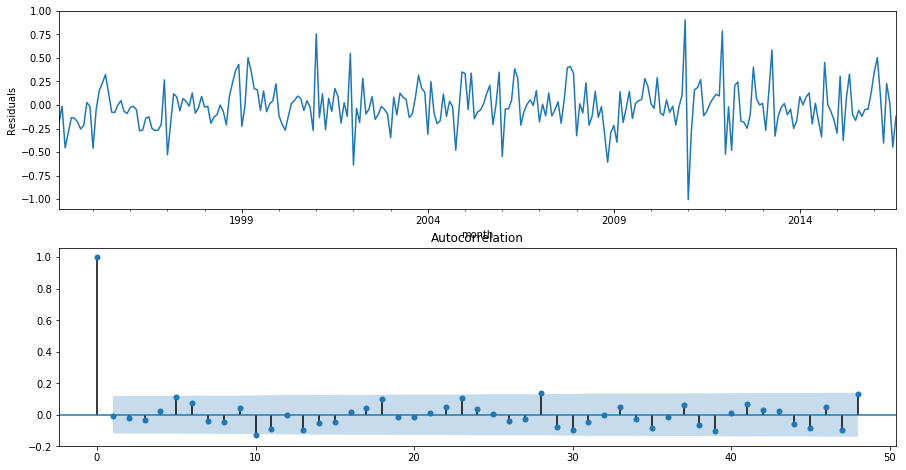

In [20]:
plt.figure(figsize(15,8))
plt.subplot(211)
simple_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(simple_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(simple_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(simple_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

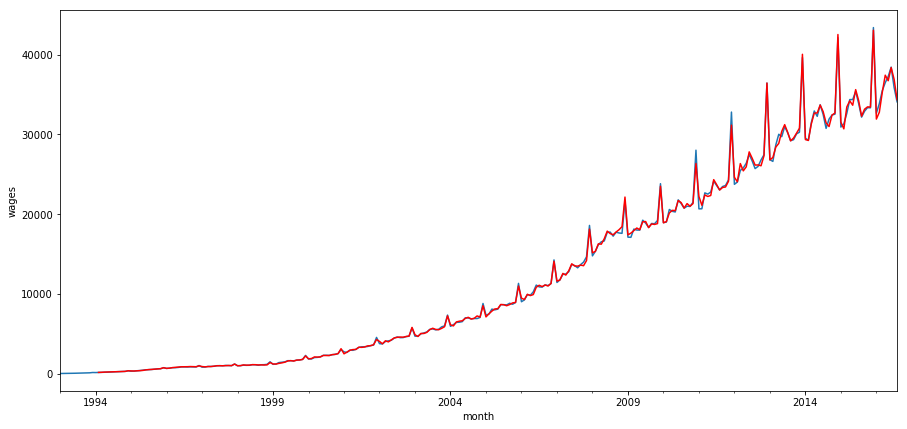

In [21]:
data['model_s'] = invboxcox(simple_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model_s[13:].plot(color='r')
plt.ylabel('wages')
pylab.show()

Для этой модели предсказания также хорошо описывают структуру данных.

### Прогноз

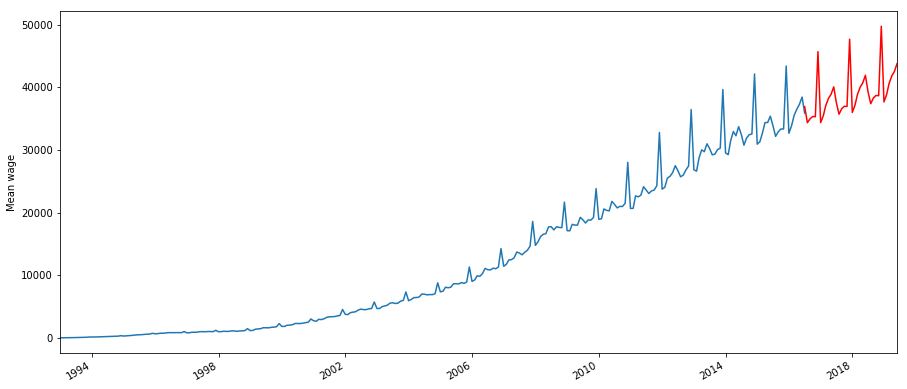

In [24]:
data3 =  data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data3.columns)
data3 = pd.concat([data3, future])
data3['forecast'] = invboxcox(simple_model.predict(start=282, end=320), lmbda)

plt.figure(figsize(15,7))
data3.WAG_C_M.plot()
data3.forecast.plot(color='r')
plt.ylabel('Mean wage')
pylab.show()

## Сравнение моделей

Как видно, результаты моделей отличаются не очень сильно. Интересно посмотреть, как сильно отличаются предсказания:

In [26]:
forecast['best_forecast'] = data2[["forecast"]][282:]
forecast['simple_forecast'] = data3[["forecast"]][282:]
forecast['diff'] = forecast['simple_forecast'] - forecast['best_forecast']
forecast

NameError: name 'forecast' is not defined